In [153]:
%reload_ext autoreload

In [64]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader

sys.path.append("/home/wangbrh/BrainProject/")
sys.path.append("/home/wangbrh/BrainProject/results")
sys.path.append("/home/wangbrh/BrainProject/utils")
sys.path.append("/home/wangbrh/BrainProject/utils/models")
sys.path.append("/home/wangbrh/BrainProject/datasets/forrest/movie_snapshots")

from utils import Datasets, plotUtils, loadUtils, featureUtils, evalUtils, models, extractRunFrames, Paths
from plotUtils import peekImageFolderDS, sampleAE, plotCompareFeatures, showAnat
from loadUtils import loadModel, loadFMRI, loadFeatures, loadPixelFeatures
from fitUtils import fitAE, fitFeatureModel, featureNetCrossVal, train_all_autoencoders, encode_all_forrest_mult_autoencoders
from evalUtils import correlateDataset

from featureUtils import generateAllFeatures, convolveFeatures
from Datasets import SingleDirDataset, FeatureDataset
from models import SimpleConvAE, SimpleConvAESmall, FeatureNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Batch Mode

In [66]:
save_name = 'march10'

# Train Autoencoder

In [67]:
image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
])
hundred_objs_ds = torchvision.datasets.ImageFolder(
    root=Paths.objects_dataset_path,
    transform=image_transforms
)
hundred_objs_dl = DataLoader(traindataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)

autoencoders = {
    'SimpleConvAE':  SimpleConvAE().cuda(),
    'SimpleConvAESmall': SimpleConvAESmall().cuda()
}

train_all_autoencoders(hundred_objs_dl, autoencoders, epochs=100, save_name=save_name)

Training SimpleConvAE model...


KeyboardInterrupt: 

## Extract Movie Frames

In [ ]:
# Run only once to extract forrest movie frames
# for i in range(8):
#     extractRunFrames(Paths.movie_run_path(i), Paths.movie_run_snapshots_path(i), 'run-{}'.format(i))

# Encode Forrest To Features

In [46]:
autoencoders = {
    'SimpleConvAE':  SimpleConvAE().cuda(),
    'SimpleConvAESmall': SimpleConvAESmall().cuda()
}
        
encode_all_forrest_mult_autoencoders(autoencoders, sa)

Encoding forrest features for SimpleConvAE model...
Encoding run 0 frames...
Feature Shape: torch.Size([454, 16384])



Encoding run 1 frames...
Feature Shape: torch.Size([444, 16384])



Encoding run 2 frames...
Feature Shape: torch.Size([441, 16384])



Encoding run 3 frames...
Feature Shape: torch.Size([491, 16384])



Encoding run 4 frames...
Feature Shape: torch.Size([465, 16384])



Encoding run 5 frames...
Feature Shape: torch.Size([442, 16384])



Encoding run 6 frames...
Feature Shape: torch.Size([545, 16384])



Encoding run 7 frames...
Feature Shape: torch.Size([340, 16384])



Feature encoding complete.
Encoding forrest features for SimpleConvAESmall model...
Encoding run 0 frames...
Feature Shape: torch.Size([454, 6144])



Encoding run 1 frames...
Feature Shape: torch.Size([444, 6144])



Encoding run 2 frames...
Feature Shape: torch.Size([441, 6144])



Encoding run 3 frames...
Feature Shape: torch.Size([491, 6144])



Encoding run 4 frames...
Feature Shape: torch.Size([465, 6144])



Encoding run 5 frames...
Feature Shape: torch.Size([442, 6144])



Encoding run 6 frames...
Feature Shape: torch.Size([545, 6144])



Encoding run 7 frames...
Feature Shape: torch.Size([340, 6144])



Feature encoding complete.


# Train BOLD Model

In [ ]:
# from torch.utils.data import DataLoader

# [anat_data, mask_data] = loadFMRI(1, 0)
# features = loadFeatures(1, 0, responseLen=anat_data.shape[3])
# features_conv = convolveFeatures(features, 2)
# # plotCompareFeatures(features[:,:10], features_conv[:,:10])
# featureData = FeatureDataset(torch.tensor(features_conv).float(), torch.tensor(anat_data), torch.tensor(mask_data).bool())
# featureLoader = DataLoader(featureData, batch_size=64, shuffle=True, num_workers=1,pin_memory=True)

In [98]:
features.shape

(451, 16384)

In [55]:
# Load encoded features datasets

import random

def loadEncodedRunDatasets(modelName, sub, save_name='', debug=False):
    all_run_datasets = []
    for i in range(8):
        [anat_data, mask_data] = loadFMRI(sub, i, debug=debug)
        features = loadFeatures(modelName, i, responseLen=anat_data.shape[3], save_name=save_name, debug=debug)
        features_conv = convolveFeatures(features, 2)
        featureData = FeatureDataset(torch.tensor(features_conv).float(), torch.tensor(anat_data), torch.tensor(mask_data).bool())
        all_run_datasets.append(featureData)
    return all_run_datasets

def loadPixelRunDataset(sub, debug=False):
    all_run_datasets = []
    for i in range(8):
        [anat_data, mask_data] = loadFMRI(sub, i, debug=debug)
        features = loadPixelFeatures(Paths.movie_run_snapshots_path(i), i, responseLen=anat_data.shape[3], debug=debug)
        features_conv = convolveFeatures(features, 2)
        featureData = FeatureDataset(torch.tensor(features_conv).float(), torch.tensor(anat_data), torch.tensor(mask_data).bool())
        all_run_datasets.append(featureData)
    return all_run_datasets

In [58]:
def experiment_all_subjects(epochs=50, save_name=''):
    
    subjects = [i for i in range (1, 5 + 1)] # 20 total subjects
    encoded_feature_types = ['Pixels', 'SimpleConvAE', 'SimpleConvAESmall']
    
    for sub in subjects:
        for encoded_feature_type in encoded_feature_types:
           
            print("Training {} on subject {}... ".format(encoded_feature_type, sub), end='')
                
            all_run_datasets = None
            if encoded_feature_type == 'Pixels':
                all_run_datasets = loadPixelRunDataset(sub)
            else:
                all_run_datasets = loadEncodedRunDatasets(encoded_feature_type, sub, save_name=save_name)
            
            save_path = os.path.join(Paths.results_path, 'sub-{:02d}'.format(sub), '{}-{}.npy'.format(encoded_feature_type, save_name))
            featureNetCrossVal(all_run_datasets, save_path, epochs=epochs)
            
            print("done.")

In [61]:
experiment_all_subjects(1, save_name)

Training Pixels on subject 1... done.
Training SimpleConvAE on subject 1... done.
Training SimpleConvAESmall on subject 1... done.
Training Pixels on subject 2... done.
Training SimpleConvAE on subject 2... done.
Training SimpleConvAESmall on subject 2... done.
Training Pixels on subject 3... done.
Training SimpleConvAE on subject 3... done.
Training SimpleConvAESmall on subject 3... done.
Training Pixels on subject 4... done.
Training SimpleConvAE on subject 4... done.
Training SimpleConvAESmall on subject 4... done.
Training Pixels on subject 5... done.
Training SimpleConvAE on subject 5... done.
Training SimpleConvAESmall on subject 5... done.


# Results

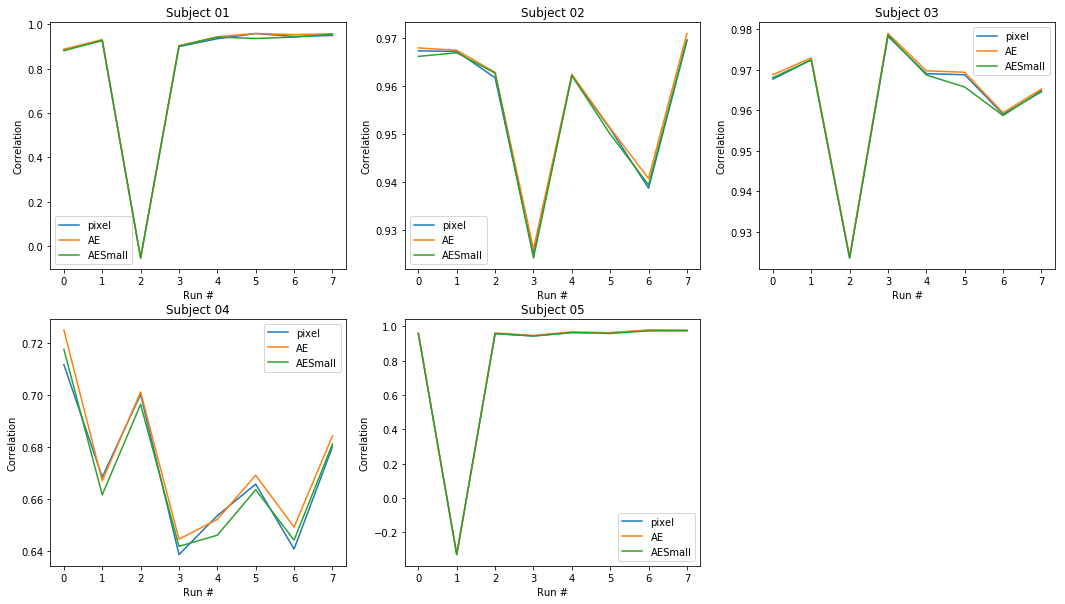

In [20]:
subjects = [i for i in range (1, 5 + 1)] # 20 total subjects
encoded_feature_types = ['Pixels', 'SimpleConvAE', 'SimpleConvAESmall']

cols = 3
rows = 2
fig = plt.figure(figsize=(cols*6, rows*5), facecolor='white')
for idx, sub in enumerate(subjects):
    fig.add_subplot(rows, cols, idx+1)
    for encoded_feature_type in encoded_feature_types:
        cv_results_path = Paths.results_path + "/sub-{:02d}/{}.npy".format(sub, encoded_feature_type)
        cv_results = np.load(cv_results_path)
        plt.plot(cv_results[:,1])
    plt.title("Subject {:02d}".format(sub))
    plt.legend(['pixel', 'AE', 'AESmall'])
    plt.xlabel("Run #")
    plt.ylabel("Correlation")
plt.show()

In [ ]:
# fit single model

train_loader = DataLoader(all_run_datasets[0], batch_size=64, pin_memory=True)

# create model, optimizer, error function
num_features = all_run_datasets[0].__getitem__(0)[0].shape[0]
num_ffa_voxels = all_run_datasets[0].__getitem__(0)[1].shape[0]
model = FeatureNet(num_features, num_ffa_voxels).cuda()
model.train()
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)


# fit and save model
fitFeatureModel(model, criterion, optimizer, train_loader, epochs=50)